# Text Classification

https://www.tensorflow.org/tutorials/text_classification_with_tf_hub

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [3]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

84131840/84125825 [==============================] - 26s 0us/step


,sentence,sentiment,polarity
0,Master cinéaste Alain Resnais likes to work wi...,7,1
1,"This is one fine movie, I can watch it any tim...",10,1
2,"OK, it's very rare that I complain something I...",2,0
3,THE SEVENTH SIGN has a great opening hook as t...,4,0
4,Rosalind Russell executes a power-house perfor...,10,1


In [8]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

In [ ]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [ ]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))
    
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('dataset/MNIST/', one_hot=True)

Extracting dataset/MNIST/train-images-idx3-ubyte.gz
Extracting dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting dataset/MNIST/t10k-labels-idx1-ubyte.gz


In [7]:
data.train.cls = np.argmax(data.train.labels, axis=1)
data.test.cls = np.argmax(data.test.labels, axis=1)


# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [8]:

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

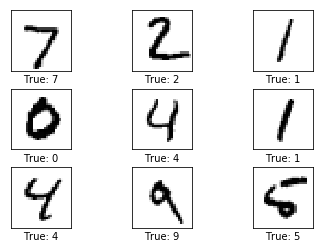

In [9]:

# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [20]:
data.train.images

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [12]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": np.array(data.train.images)},
    y=np.array(data.train.cls),
    num_epochs=None,
    shuffle=True)

In [13]:
train_input_fn()

({'x': <tf.Tensor 'random_shuffle_queue_DequeueMany_1:1' shape=(128, 784) dtype=float32>},
 <tf.Tensor 'random_shuffle_queue_DequeueMany_1:2' shape=(128,) dtype=int64>)

In [14]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": np.array(data.test.images)},
    y=np.array(data.test.cls),
    num_epochs=1,
    shuffle=False)

some_images = data.test.images[0:9]
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": some_images},
    num_epochs=1,
    shuffle=False)

some_images_cls = data.test.cls[0:9]


In [15]:
feature_x = tf.feature_column.numeric_column("x", shape=img_shape)
feature_columns = [feature_x]
num_hidden_units = [512, 256, 128]
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                   hidden_units=num_hidden_units,
                                   activation_fn=tf.nn.relu,
                                   n_classes=num_classes,
                                   model_dir="./checkpoints_tutorial17-1/")
model.train(input_fn=train_input_fn, steps=2000)


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial17-1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12ed8a400>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial17-1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12ed8a400>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into ./checkpoints_tutorial17-1/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into ./checkpoints_tutorial17-1/model.ckpt.


INFO:tensorflow:loss = 291.833, step = 1


INFO:tensorflow:loss = 291.833, step = 1


INFO:tensorflow:global_step/sec: 96.9349


INFO:tensorflow:global_step/sec: 96.9349


INFO:tensorflow:loss = 23.7635, step = 101 (1.033 sec)


INFO:tensorflow:loss = 23.7635, step = 101 (1.033 sec)


INFO:tensorflow:global_step/sec: 114.858


INFO:tensorflow:global_step/sec: 114.858


INFO:tensorflow:loss = 14.9305, step = 201 (0.871 sec)


INFO:tensorflow:loss = 14.9305, step = 201 (0.871 sec)


INFO:tensorflow:global_step/sec: 107.4


INFO:tensorflow:global_step/sec: 107.4


INFO:tensorflow:loss = 22.8174, step = 301 (0.934 sec)


INFO:tensorflow:loss = 22.8174, step = 301 (0.934 sec)


INFO:tensorflow:global_step/sec: 99.7695


INFO:tensorflow:global_step/sec: 99.7695


INFO:tensorflow:loss = 27.4525, step = 401 (1.002 sec)


INFO:tensorflow:loss = 27.4525, step = 401 (1.002 sec)


INFO:tensorflow:global_step/sec: 109.92


INFO:tensorflow:global_step/sec: 109.92


INFO:tensorflow:loss = 8.04661, step = 501 (0.908 sec)


INFO:tensorflow:loss = 8.04661, step = 501 (0.908 sec)


INFO:tensorflow:global_step/sec: 122.413


INFO:tensorflow:global_step/sec: 122.413


INFO:tensorflow:loss = 12.8016, step = 601 (0.817 sec)


INFO:tensorflow:loss = 12.8016, step = 601 (0.817 sec)


INFO:tensorflow:global_step/sec: 112.691


INFO:tensorflow:global_step/sec: 112.691


INFO:tensorflow:loss = 7.12285, step = 701 (0.890 sec)


INFO:tensorflow:loss = 7.12285, step = 701 (0.890 sec)


INFO:tensorflow:global_step/sec: 131.61


INFO:tensorflow:global_step/sec: 131.61


INFO:tensorflow:loss = 17.873, step = 801 (0.757 sec)


INFO:tensorflow:loss = 17.873, step = 801 (0.757 sec)


INFO:tensorflow:global_step/sec: 134.062


INFO:tensorflow:global_step/sec: 134.062


INFO:tensorflow:loss = 2.61137, step = 901 (0.746 sec)


INFO:tensorflow:loss = 2.61137, step = 901 (0.746 sec)


INFO:tensorflow:global_step/sec: 126.045


INFO:tensorflow:global_step/sec: 126.045


INFO:tensorflow:loss = 9.08272, step = 1001 (0.794 sec)


INFO:tensorflow:loss = 9.08272, step = 1001 (0.794 sec)


INFO:tensorflow:global_step/sec: 122.038


INFO:tensorflow:global_step/sec: 122.038


INFO:tensorflow:loss = 9.02956, step = 1101 (0.820 sec)


INFO:tensorflow:loss = 9.02956, step = 1101 (0.820 sec)


INFO:tensorflow:global_step/sec: 126.425


INFO:tensorflow:global_step/sec: 126.425


INFO:tensorflow:loss = 8.44778, step = 1201 (0.791 sec)


INFO:tensorflow:loss = 8.44778, step = 1201 (0.791 sec)


INFO:tensorflow:global_step/sec: 134.826


INFO:tensorflow:global_step/sec: 134.826


INFO:tensorflow:loss = 5.53391, step = 1301 (0.741 sec)


INFO:tensorflow:loss = 5.53391, step = 1301 (0.741 sec)


INFO:tensorflow:global_step/sec: 130.073


INFO:tensorflow:global_step/sec: 130.073


INFO:tensorflow:loss = 3.43587, step = 1401 (0.769 sec)


INFO:tensorflow:loss = 3.43587, step = 1401 (0.769 sec)


INFO:tensorflow:global_step/sec: 122.365


INFO:tensorflow:global_step/sec: 122.365


INFO:tensorflow:loss = 7.81507, step = 1501 (0.817 sec)


INFO:tensorflow:loss = 7.81507, step = 1501 (0.817 sec)


INFO:tensorflow:global_step/sec: 128.731


INFO:tensorflow:global_step/sec: 128.731


INFO:tensorflow:loss = 12.6725, step = 1601 (0.777 sec)


INFO:tensorflow:loss = 12.6725, step = 1601 (0.777 sec)


INFO:tensorflow:global_step/sec: 120.61


INFO:tensorflow:global_step/sec: 120.61


INFO:tensorflow:loss = 1.53687, step = 1701 (0.830 sec)


INFO:tensorflow:loss = 1.53687, step = 1701 (0.830 sec)


INFO:tensorflow:global_step/sec: 104.481


INFO:tensorflow:global_step/sec: 104.481


INFO:tensorflow:loss = 9.24538, step = 1801 (0.956 sec)


INFO:tensorflow:loss = 9.24538, step = 1801 (0.956 sec)


INFO:tensorflow:global_step/sec: 108.736


INFO:tensorflow:global_step/sec: 108.736


INFO:tensorflow:loss = 10.0878, step = 1901 (0.921 sec)


INFO:tensorflow:loss = 10.0878, step = 1901 (0.921 sec)


INFO:tensorflow:Saving checkpoints for 2000 into ./checkpoints_tutorial17-1/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into ./checkpoints_tutorial17-1/model.ckpt.


INFO:tensorflow:Loss for final step: 5.75847.


INFO:tensorflow:Loss for final step: 5.75847.
